In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns;
sns.set()

### Manifold Learning:"HELLO"

In [5]:
def make_hello(N=1000,rseed=42):
    #make a plot with "HELLO"text, save as PNG
    fig, ax=plt.subplots(figsize=(4,1))
    fig.subplots_adjust(left=0,right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5,0.4,'HELLO', va='center', ha='center', weight='bold',size=85)
    fig.savefig('hello.png')
    plt.close(fig)
    
    #open this PNG and draw random points from it
    from matplotlib.image import imread
    data=imread('hello.png')[::-1,:,0].T
    rng=np.random.RandomState(rseed)
    X=rng.rand(4*N,2)
    i,j=(X*data.shape).astype(int).T
    mask=(data[i,j]<1)
    X=X[mask]
    X[:,0]*=(data.shape[0]/data.shape[1])
    X=X[:N]
    return X[np.argsort(X[:,0])]

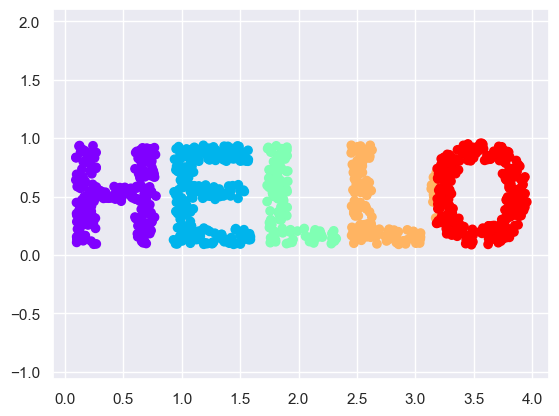

In [6]:
X=make_hello(1000)
colorize=dict(c=X[:,0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:,0], X[:,1], **colorize)
plt.axis('equal');

### Multidimensional Scalling(MDS)

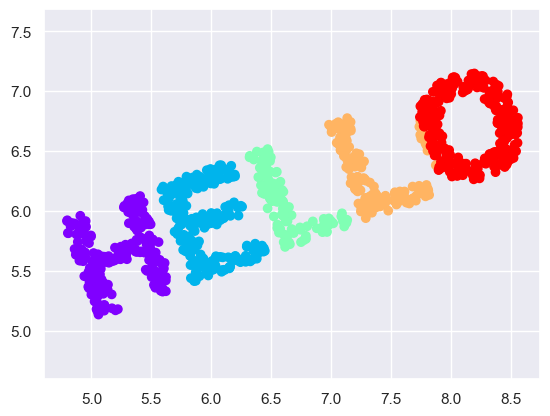

In [7]:
#note:choice of x and y values of a dataset are not the most fundamental description of the data
#this is because you can rotate,shrink,or scale the data and the 'HELLO' will still be apparent
def rotate(X, angle):
    theta=np.deg2rad(angle)
    R=[[np.cos(theta),np.sin(theta)],
      [-np.sin(theta), np.cos(theta)]]
    return np.dot(X,R)

X2=rotate(X,20)+5
plt.scatter(X2[:,0],X2[:,1], **colorize)
plt.axis('equal');

In [8]:
#inthis case, knowing the distance from point i to j is the most fundamental

from sklearn.metrics import pairwise_distances
D=pairwise_distances(X)
D.shape

(1000, 1000)

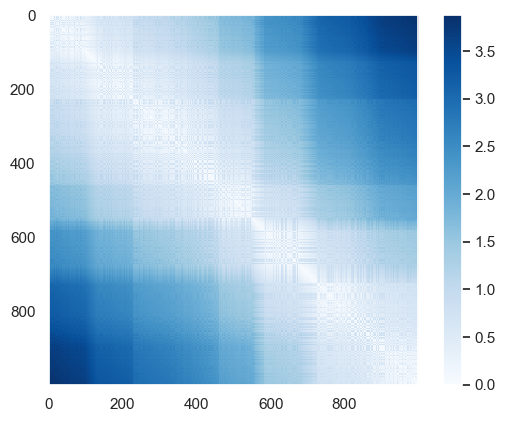

In [9]:
#visualize the matrix

plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

In [11]:
#constuct a distance matrix for the rotated and translated data, it's actually the same
D2=pairwise_distances(X2)
np.allclose(D,D2)

True

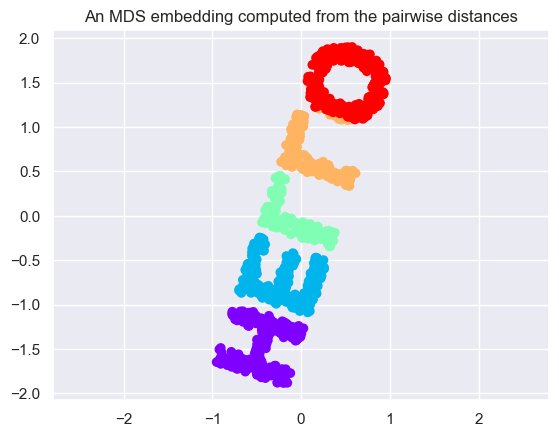

In [13]:
# how MDS work

from sklearn.manifold import MDS
model=MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out=model.fit_transform(D)
plt.scatter(out[:,0],out[:,1], **colorize)
plt.title('An MDS embedding computed from the pairwise distances')
plt.axis('equal');

### MDS as Manifold Learning

In [16]:
def random_projection(X, dimension=3, rseed=42):
    assert dimension>= X.shape[1]
    rng=np.random.RandomState(rseed)
    C=rng.randn(dimension, dimension)
    e,V=np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X,V[:X.shape[1]])

X3=random_projection(X,3)
X3.shape

(1000, 3)

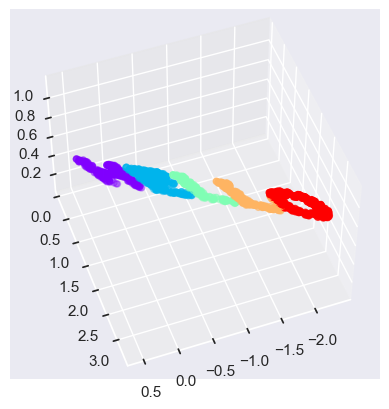

In [20]:
#visualize these points
from mpl_toolkits import mplot3d
ax=plt.axes(projection='3d')
ax.scatter3D(X3[:,0], X3[:,1], X3[:,2],**colorize)
ax.view_init(azim=70, elev=50)

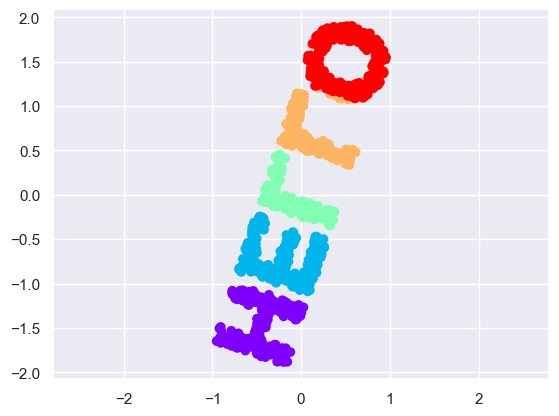

In [21]:
#the MDS estimator inputs this three-dimensional data, computes the distance matrix, and then determines
#the optimal two-dimensional embedding for this distance matrix.
#The result recovers a representation of the original data

model=MDS(n_components=2, random_state=1)
out3=model.fit_transform(X3)
plt.scatter(out3[:,0], out3[:,1], **colorize)
plt.axis('equal');

### Nonlinear Embendings: Where MDS Fails

In [30]:
def make_hello_s_curve(X):
    t=(X[:,0]-2)*0.75*np.pi
    x=np.sin(t)
    y=X[:,1]
    z=np.sign(t)*(np.cos(t)-1)
    return np.vstack((x,y,z)).T

XS=make_hello_s_curve(X)

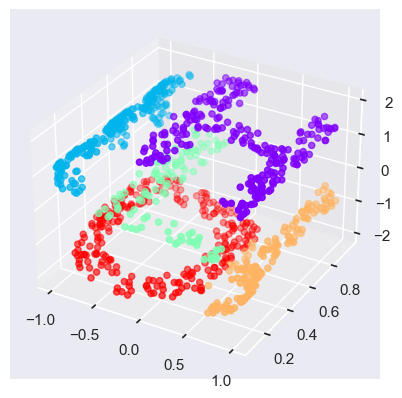

In [31]:
from mpl_toolkits import mplot3d
ax=plt.axes(projection='3d')
ax.scatter3D(XS[:,0],XS[:,1],XS[:,2], 
             **colorize);

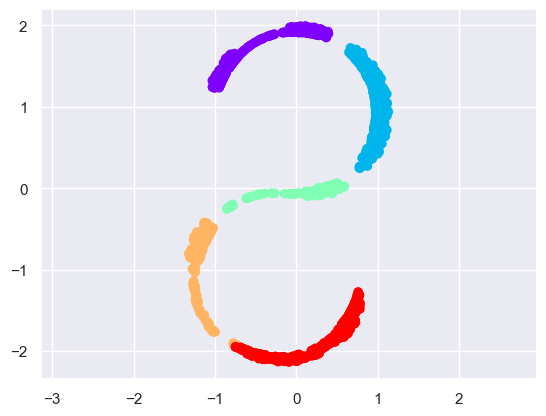

In [32]:
#try a simple MDS algorithm on this data, it's not able to 'unwrap'the linear embending
from sklearn.manifold import MDS
model=MDS(n_components=2, random_state=2)
outS=model.fit_transform(XS)
plt.scatter(outS[:,0],outS[:,1],**colorize)
plt.axis('equal');

### Nonlinear Manifolds: Locally Linear Embedding
    

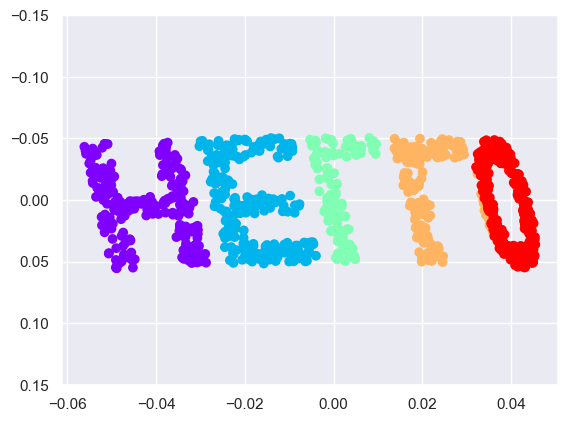

In [33]:
#LLE can recover the undelying data from a non-linearly embedded input
from sklearn.manifold import LocallyLinearEmbedding
model=LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified',
                            eigen_solver='dense')
out=model.fit_transform(XS)

fig,ax=plt.subplots()
ax.scatter(out[:,0],out[:,1], **colorize)
ax.set_ylim(0.15,-0.15);

### Example: Isomap on Faces

In [34]:
from sklearn.datasets import fetch_lfw_people
faces=fetch_lfw_people(min_faces_per_person=30)
faces.data.shape

URLError: <urlopen error [Errno 11001] getaddrinfo failed>

NameError: name 'faces' is not defined

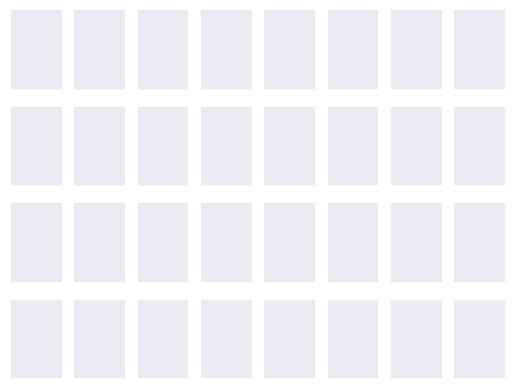

In [37]:
fig, ax= plt.subplots(4,8, subplot_kw=dict(xticks=[],yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

In [38]:
from sklearn.decomposition import PCA as RandomizedPCA
model=RandomizedPCA(100).fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance');

NameError: name 'faces' is not defined

In [39]:
#you can use LLE or Isomap 
from sklearn.manifold import Isomap
model=Isomap(n_components=2)
proj=model.fit_transform(faces.data)
proj.shape

NameError: name 'faces' is not defined

In [40]:
#define a funtion that will output image thumbnails at the locations of the projections

from matplotlib import offsetbox

def plot_components(data,model, images=None, ax=None,
                   thumb_frac=0.05, cmap='gray'):
    ax=ax or plt.gca()
    
    proj=model.fit_transform(data)
    ax.plot(proj[:,0], proj[:,1], '.k')
    
    if images is not None:
        min_dist_2=(thumb_frac*max(proj.max(0)-proj.min(0)))**2
        shown_images=np.array([2*proj.max(0)])
        for i in range(data.shape[0]):
            dist=np.sum((proj[i]-shown_images)**2, 1)
            if np.min(dist)<min_dist_2:
                #don't show points that are too close
                continue 
            shown_images=np.vstack([shown_images, proj[i]])
            imagebox=offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(images[i], cmap=cmap), proj[i])
            
            ax.add_artist(imagebox)

NameError: name 'faces' is not defined

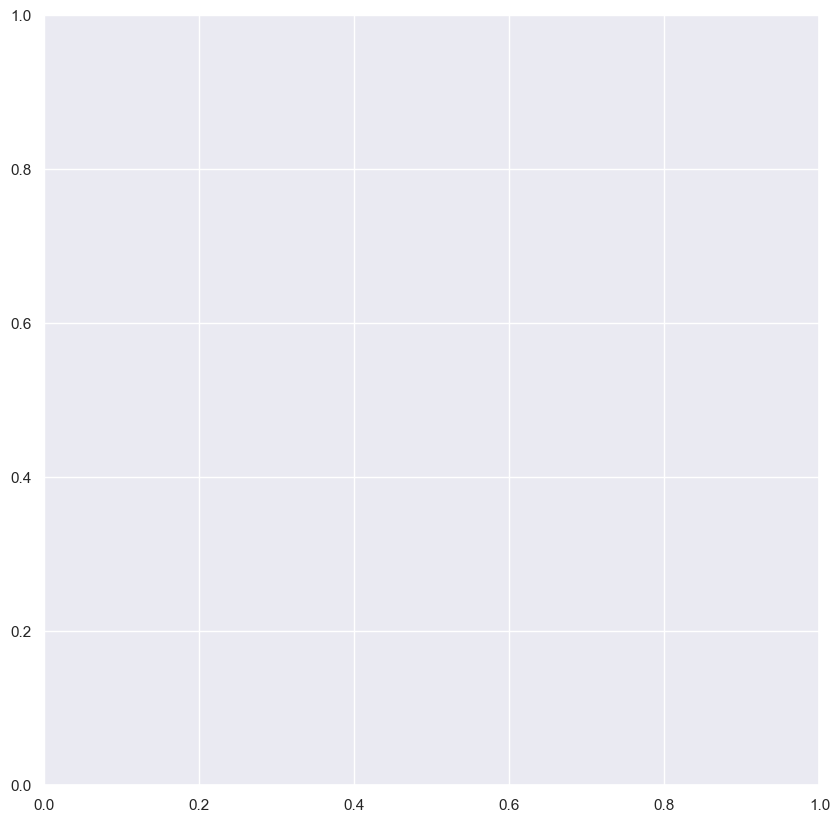

In [41]:
fig, ax=plt.subplots(figsize=(10,10))
plot_components(faces.data,
               model=Isomap(n_components=2),
               images=faces.images[:,::2,::2])

### Example: Visualizing Structure in Digits

In [55]:
from sklearn.datasets import fetch_openml
mnist=fetch_openml('mnist_784')
mnist.data.shape

URLError: <urlopen error [Errno 11001] getaddrinfo failed>

AttributeError: 'function' object has no attribute 'data'

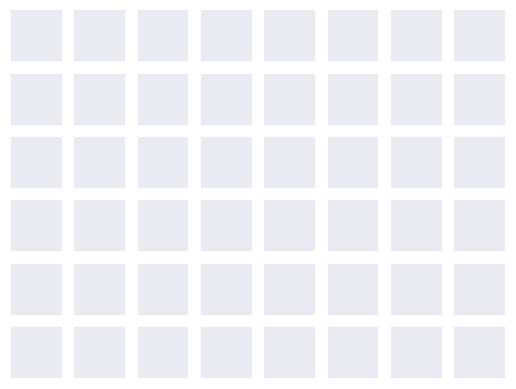

In [56]:
fig, ax=plt.subplots(6,8, subplot_kw=dict(xticks=[],yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(mnist.data[1250*i].reshape(28,28), cmap='gray_r')

In [57]:
#use only 1/30 of the data:full dataset takes a long time
data=mnist.data[::30]
target=mnist.target[::30]

model=Isomap(n_components=2)
proj=model.fit_transform(data)
plt.scatter(proj[:,0],proj[:,1], c=target, cmap=plt.cm.get_cmap('jet',10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5,9.5);

AttributeError: 'function' object has no attribute 'data'

In [58]:
#gain more insight of the data by looking a single number at a time
#choose 1/4 of the "1" digits to project
data=mnist.data[mnist.target==1][::4]

fig, ax=plt.subplots(figsize=(10,10))
model=Isomap(n_neighbors=5, n_components=2, eigen_solver='dense')
plot_components(data, model, images=data.reshape((-1,28,28)),
               ax=ax, thumb_frac=0.05, cmap='gray_r')


AttributeError: 'function' object has no attribute 'data'